This is the open source code of paper: Utilizing Domain Knowledge: Robust Machine Learning for Building Energy Prediction with Small, Inconsistent Datasets.
@Date : 2022-06-24 16:21:35
@Link : https://arxiv.org/abs/2302.10784
@Ver : v02
@Author: Xia CHEN (xia.chen@iek.uni-hannover.de), Xia Chen, Manav Mahan Singh, Philipp Geyer
For using the code or data, please cite:

*- Chen, X., Singh, M.M. and Geyer, P., 2023. Utilizing Domain Knowledge: Robust Machine Learning for Building Energy Prediction with Small, Inconsistent Datasets. arXiv preprint arXiv:2302.10784.*

*- CHEN, Xia; Singh, Manav Mahan; Geyer, Philipp (2023), “Utilizing domain knowledge: robust machine learning for building energy performance prediction with small, inconsistent datasets”, Mendeley Data, V2, doi: 10.17632/fctghwx3r9.2*

---
This code is designed for training, testing, and evaluating machine learning models for monolithic building level model, as well as component and zone level models, with a focus on building energy consumption prediction. Available ML models are: `DecisionTree`, `SGDRegressor`, `LightGBM`. They are involved in proving that the effectiveness of Component-based Machine Learning framework is model-independent. It follows a structured process from data preparation, model training, and evaluation to result visualization. Here’s a breakdown:

---

1. **Model Parameters and Training Function**
- **Function Definition (`train_test_df`)**: This function is designed to handle the preprocessing of training and testing datasets, conduct model training or loading, perform predictions, and evaluate the results using metrics like RMSE, SMAPE, MAE, MSE, and R². It also manages feature importance visualization and model persistence.
  - **Data Split**: Extracts features (`X`) and targets (`y`) for training and testing datasets.
  - **Dataset Preparation**: Prepares LightGBM datasets for training.
  - **Directory Creation**: Creates a directory based on the component and target variable to store outputs.
  - **Conditional Training**: If `TRAINING` is True, it trains the model using cross-validation to find the optimal number of boosting rounds and then retrains the model on the entire dataset using these rounds. Otherwise, it loads an existing model.
  - **Result DataFrame & Evaluation**: Generates a DataFrame for test results and prints evaluation metrics.
  - **Feature Importance Visualization**: Saves a plot of feature importances.
  - **Model Saving**: Conditionally saves the trained model for future use.
  - **Logging**: Appends model performance metrics to a `result.csv` file for logging purposes.
  - **Data Adjustment for Output**: Modifies the test DataFrame to include relevant indices and names for different components, saving it for future analysis.
---
2. **Global Parameters and Preprocessing**
- **Variable Definitions**: Sets up global parameters like version, seed, CPU cores, and LightGBM parameters for reproducibility and performance optimization.
- **Result Heading**: Initializes or appends a heading to the `result.csv` file for logging model results.
---
3. **Data Reading and Feature Definition**
- Iterates through components (presumably files representing different building segments or conditions) to read datasets, adjust column names, define input and output features based on the component type (Building, Zone, etc.), and exclude irrelevant features.
---
4. **Model Training Invocation**
- For each target feature defined per component, it calls the `train_test_df` function to train/test the model, providing component-specific datasets, features, and parameters.
---
5. **Visualization**
- Processes files for visualization, adjusting DataFrame indices and columns for a comprehensive view.
- Utilizes Plotly for generating line plots comparing actual and predicted values over time, saved as images for each analyzed component.
---
This structured approach allows for a scalable and flexible analysis of building energy consumption, accommodating various building components and conditions. The inclusion of result logging and visualization aids in the interpretation and presentation of the model's predictive performance and feature importance.

In [ ]:
# Building performance simulation, component

import pandas as pd
import numpy as np
import os, sys, gc, time, warnings, pickle, psutil, random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import csv
from math import ceil

from tqdm import tqdm

import plotly.offline as py                   
py.init_notebook_mode(connected=True)          
import plotly.graph_objs as go                 
import plotly.figure_factory as ff             
from plotly.offline import init_notebook_mode, plot_mpl


# Target plot
import seaborn as sns, matplotlib.pyplot as plt
import random 

# model training
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# pd.set_option('max_columns', 100)

warnings.filterwarnings('ignore')
ROUTE = '../_TrainData_done/'
ROUTE_test = '../_TestData_done/'
# whether training or not
TRAINING = False

g = os.walk(ROUTE)  

files = []
for path,dir_list,file_list in g:  
    for file_name in file_list:  
        files.append(file_name)
print(files)
PERIOD = files[0].split('_')[1][:-4]
# files = files[0:1]
files

In [2]:
########################### Helpers #################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def mkdir(path):
    path=path.strip()
    path=path.rstrip("\\")
    isExists=os.path.exists(path)
    if not isExists:
        os.makedirs(path) 
        
# Result & Evaluation
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def SMAPE(F, A):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


def MAE(F, A):
    return 1/len(A) * np.sum(np.abs(F - A))


def MSE(F, A):
    return 1/len(A) * np.sum(pow(np.abs(F - A),2))

# check the value distribution of training output, it's important for hyperparameter tuning
def plot_target(df, TARGET):
    plt.figure(figsize=(20,12))
    plot_df = df[TARGET]
    # his_grid = random.sample(list(plot_df), 10000)

    sns.distplot(plot_df,label=TARGET)
    plt.legend(loc='upper right')
    plt.show()
    print('Done!')

In [3]:
import re
from sklearn.preprocessing import StandardScaler  
from sklearn import svm, tree
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

########################### Model params #################################################################################

def train_test_df(component, df, df_test, lgb_params, features, TARGET, TRAINING=True):
    
    # spilt Train/Test
    X_train = df[features]
    y_train = df[TARGET]

    X_test = df_test[features]
    y_test = df_test[TARGET]
    
#     # Test on different ML models
#     scaler = StandardScaler()  
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
#     # save the scaler
#     regr = tree.DecisionTreeRegressor()
#     regr.fit(X_train, y_train)
    
#     y_pred = regr.predict(X_test)
#     print('DecisionTree',r2_score(y_test, y_pred))

#     regr= linear_model.SGDRegressor()
#     regr.fit(X_train, y_train)
#     y_pred = regr.predict(X_test)
#     print('SGDRegressor', r2_score(y_test, y_pred))
    
    
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    train_data = lgb.Dataset(X_train, 
                       label=y_train)

    ############################ Make dir ###########################
    TARGET_ = TARGET.replace(':','_')
    mkdir(component + '_' + TARGET_)
    
    ############################ Training ############################
    if(TRAINING == True):
        estimator = lgb.cv(
                            lgb_params,
                            train_data,
                            num_boost_round=200000,
                            nfold=3,
                            early_stopping_rounds=300,
                            verbose_eval=2000,
                            stratified=False,
                            seed=42
        )
        rounds = int(len(estimator['rmse-mean']))
        print('The best RMSE in CV is {:.5f}，std {:.5f}.'.format(
        estimator['rmse-mean'][-1], estimator['rmse-stdv'][-1]))

        print('The best iteration round is {}.'.format(len(estimator['rmse-mean'])))
    
        estimator = lgb.train(lgb_params,
                              train_data,
                              verbose_eval = 1000,
                              num_boost_round = int(len(estimator['rmse-mean'])), ###########
                              )
    elif(TRAINING == False):
        estimator = lgb.Booster(model_file= component + '_' + TARGET_ + '/' + TARGET_ + '_model.txt')
        rounds = 0
        print('Model loaded!')
    ############################ Making result df ############################
    test_df = pd.DataFrame(y_test)
    test_df['pred'] = estimator.predict(X_test)

    ############################ Result evaluation ###########################
    msg = 'Result RMSE is {}, SMAPE is {}, MAE is {}, MSE is {}, R^2 is {}'.format('%.4f' % RMSE(test_df['pred'],test_df[TARGET]), 
                                                             '%.4f' % SMAPE(test_df['pred'],test_df[TARGET]), 
                                                             '%.4f' % MAE(test_df['pred'],test_df[TARGET]),
                                                             '%.4f' % MSE(test_df['pred'],test_df[TARGET]),
                                                             '%.4f' % metrics.r2_score(test_df[TARGET],test_df['pred']))
    print(msg)

    ########################### Feature importance ##########################
    plt.rcParams["figure.figsize"] = (10,10)
    # mean decrease impurity
    imp_img = lgb.plot_importance(estimator, ignore_zero=False)
    imp_img.figure.savefig(component + '_' + TARGET_ + '/' + TARGET_ + '_feature_imp.png')
#     imp_img.save_img(TARGET + '/' + TARGET + '_feature_imp.png')
    ########################### save model ##############################
    if(TRAINING == True):
        estimator.save_model(component + '_' + TARGET_ + '/' + TARGET_ + '_model.txt')
#     #load from model:
#     bst = lgb.Booster(model_file='mode.txt')
    ########################### log result ##############################
    with open("result.csv","a+", newline='') as csvfile: 
        writer = csv.writer(csvfile)
        writer.writerows([[component, TARGET, str(rounds), str(RMSE(test_df['pred'],test_df[TARGET])), str(SMAPE(test_df['pred'],test_df[TARGET])),str(MAE(test_df['pred'],test_df[TARGET])), str(MSE(test_df['pred'],test_df[TARGET])), str(metrics.r2_score(test_df[TARGET],test_df['pred'])), len(features)]])
    if(component[0] == 'B'):
        test_df['File'] = df_test.index
    elif(component[0] == 'Z'):
        test_df['File'] = df_test.index
        test_df['Zone Name'] = df_test['Name']
    else:
        test_df['File'] = df_test.index
        test_df['Zone Name'] = df_test['Zone Name']
        test_df['Name'] = df_test['Name']
    test_df.to_csv(component + '_' + TARGET_ + '/' + TARGET_ + '.csv')
    return estimator

In [4]:
files[0][0]

'B'

BuildingTypicalDays_Winter Typical.csv
['Month', 'Day', 'Hour', 'Temp', 'Dew', 'Hum', 'Pres', 'Floor Area', 'Height', 'Volume', 'Number of Floors', 'Total Heat Capacity', 'u-Value (Wall)', 'u-Value (Ground Floor)', 'u-Value (Roof)', 'u-Value (Internal Floor)', 'u-Value (Internal Wall)', 'u-Value (Windows)', 'g-Value (Windows)', 'Heat Capacity (Floor Slabs)', 'Infiltration', 'Permeability', 'Internal Mass', 'WWR (North)', 'WWR (East)', 'WWR (West)', 'WWR (South)', 'Building_Start Time', 'Building_Operating Hours', 'Building_Light Heat Gain', 'Building_Equipment Heat Gain', 'Building_Occupancy', 'Building_Heating Setpoint', 'Building_Cooling Setpoint', 'Boiler Efficiency', 'Heating COP', 'Cooling COP']
Now dealing Winter Typical_Heating Load
Model loaded!
Result RMSE is 4287.1876, SMAPE is 60.6669, MAE is 2721.1580, MSE is 18379977.6603, R^2 is 0.9780
GFloorTypicalDays_Winter Typical.csv
['Month', 'Day', 'Hour', 'Temp', 'Dew', 'Hum', 'Pres', 'Area', 'u-Value (Ground Floor)', 'Heat Capaci

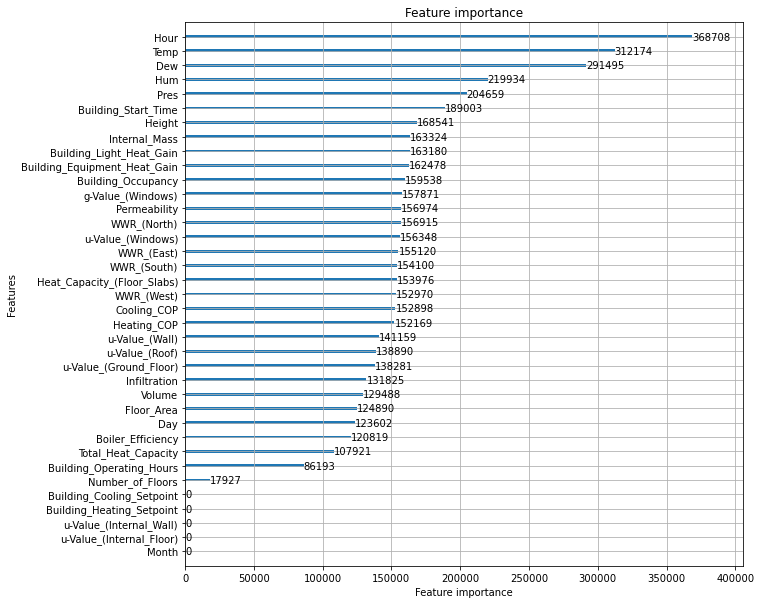

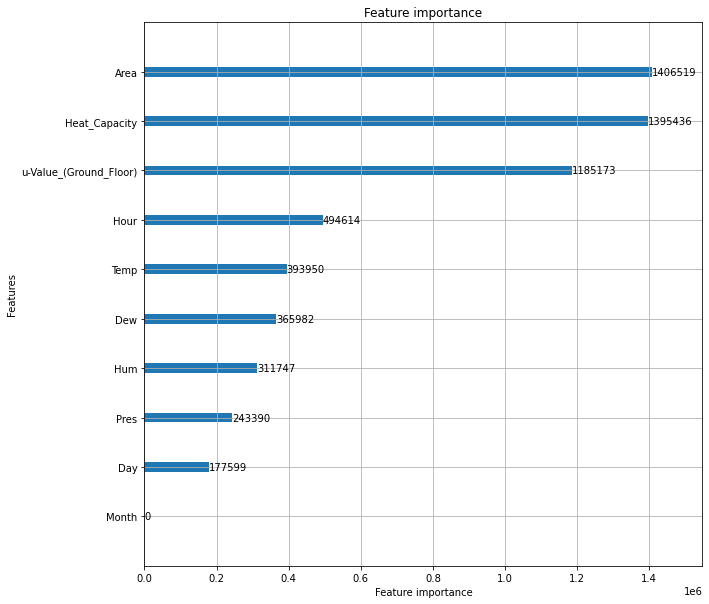

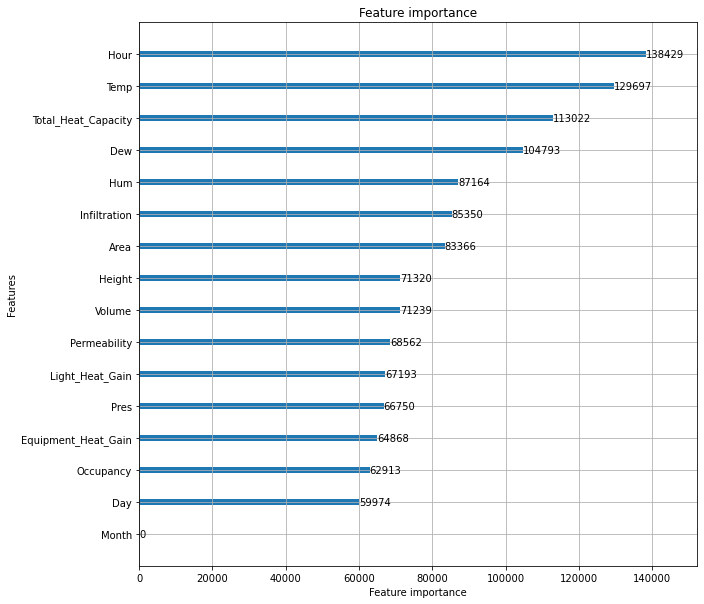

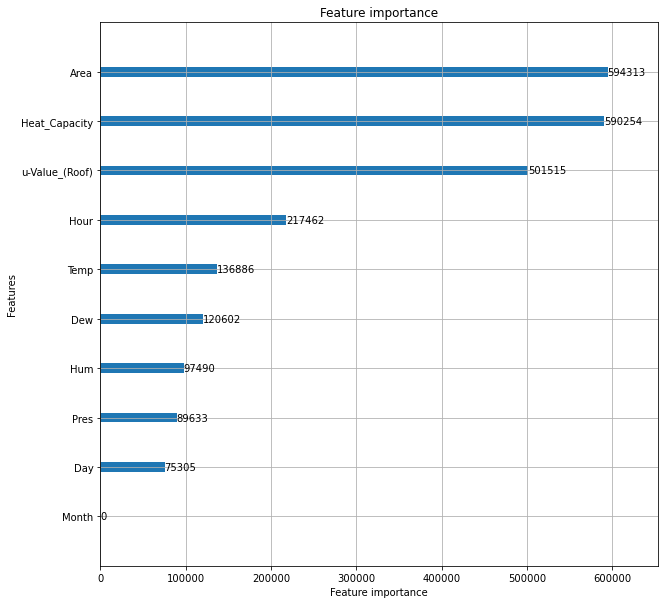

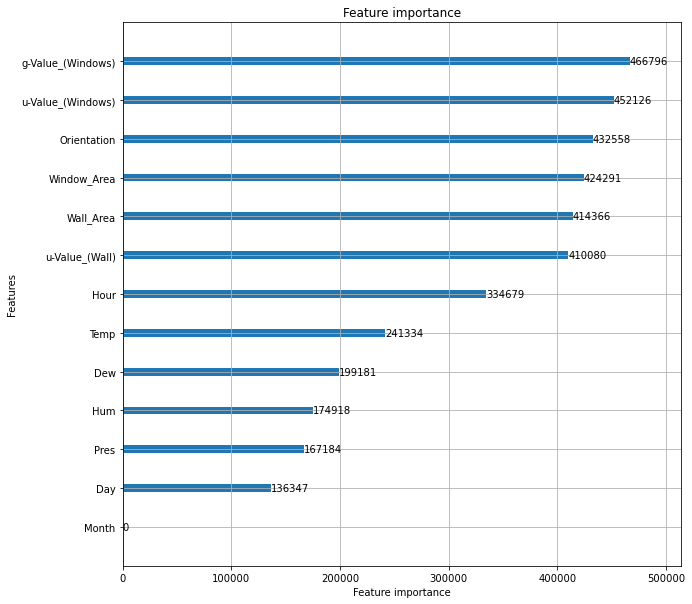

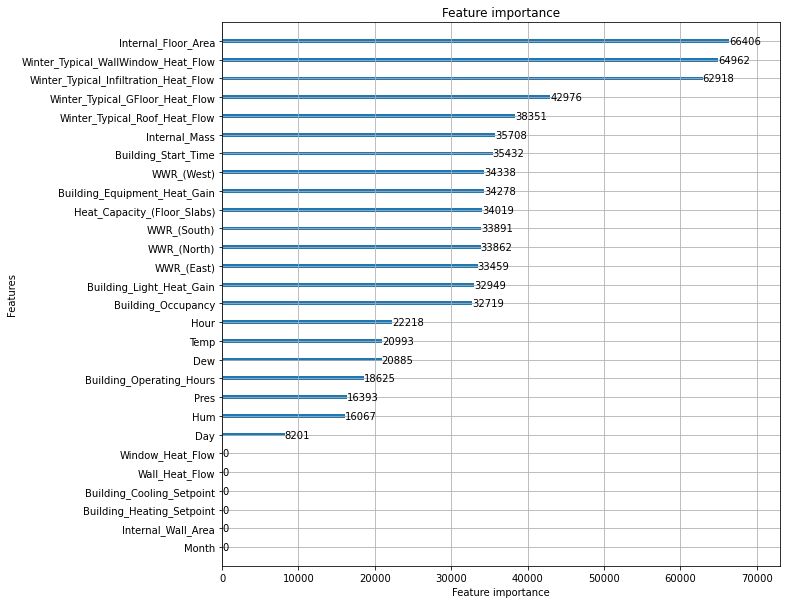

In [5]:
########################### Vars #################################################################################
VER = 1                          # Version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
N_CORES = psutil.cpu_count()     # Available CPU cores

lgb_params = {
            'boosting_type': 'gbdt',
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.15,
#             'num_leaves': 2**5-1,
#             'min_data_in_leaf': 2**6-1,
            'feature_fraction': 0.8,
#             'max_bin': 50,
#             'n_estimators': 1400,
            'boost_from_average': False,
            'verbose': -1,
            'n_jobs': -1,
            }

lgb_params['seed'] = SEED        # as possible

############################ write heading ####################################
with open("result.csv","a+", newline='') as csvfile: 
    writer = csv.writer(csvfile)
    #先写入columns_name
    writer.writerow(["Component", "Target", "Round", "RMSE", "SMAPE", "MAE", "MSE", "R2", "Feature_num"])
    
########################### Read data ####################################
# files = files[1:]
for component in files:
    print(component)
    df = pd.read_csv(ROUTE+component, index_col=0)
    df = df.set_index('File')
    words = df.columns.values.tolist()
    w = [w.replace(':', '_') for w in words]
#     print()
    df.columns = w
    
#     df.head()
    
    df_test = pd.read_csv(ROUTE_test+component, index_col=0)
    df_test = df_test.set_index('File',drop=True)
    df_test.columns = w
#     df_test.head()
    

    ########################## input & output definition
    # define output target & input features

    # building
    if(component[0] ==  "B"):
#         Target_features = ['Heating Load', 'Cooling Load', 'Lights Load', 'Thermal Energy', 'Operational Energy', 'EUI']
        Target_features = [ PERIOD + '_Heating Load']
        remove_features = ['Year', 'External Wall Area', 'Ground Floor Area', 'Roof Area', 'Window Area']
    # Zone 
    elif(component[0] ==  "Z"):    
#         Target_features = ['Heating Load', 'Cooling Load', 'Lights Load']
        Target_features = [ PERIOD + '_Heating Load']
        remove_features = ['Year']
        # with origin input
#         remove_features = ['Name', 'WallWindow Heat Flow', 'GFloor Heat Flow', 'Roof Heat Flow', 'Infiltration Heat Flow']
        # with Intermediate variable
        remove_features = [
                            'Name','Year',
                           # Infiltration
                           'Area', 'Height', 'Volume', 'Infiltration', 'Permeability', 'Internal Heat Gain', 'Total Heat Capacity',
                           # WallWindow (miss Orientation)
                           'External Wall Area', 'Window Area', 'u-Value (Wall)', 'u-Value (Windows)', 'g-Value (Windows)', 'Solar Radiation',
                           # Roof (miss Heat Capacity)
                           'Roof Area', 'u-Value (Roof)',
                           # GFloor (miss Heat Capacity)
                           'Ground Floor Area', 'u-Value (Ground Floor)', 'u-Value (Internal Floor)', 'u-Value (Internal Wall)'
                          ]

        
    else:
        # GFloor, Infiltration, Roof, WallWindow
        Target_features = [ PERIOD + '_Heat Flow']
        remove_features = ['Year', 'Zone Name', 'Name']

    # ==================
    Input_features = Target_features + remove_features
    features = [col for col in list(df) if col not in Input_features]
    print(features)
    ###################### Start training ######################
    for TARGET in Target_features:
    #   TARGET = Target_features[1]
        print('Now dealing',TARGET)
        # plot_target(df, TARGET)
        train_test_df(component[:-4], df, df_test, lgb_params, features, TARGET, TRAINING = TRAINING)

In [7]:
################### Visualization
for component in files:
# component = files[4]
    print(component)
    df = pd.read_csv(ROUTE+component, index_col=0)
    df = df.set_index('File',drop=True)
    df.head()

    df_test = pd.read_csv(ROUTE_test+component)
    df_test = df_test.set_index('File',drop=True)
    df_test.head()

    # building
    if(component[0] ==  "B"):
    #         Target_features = ['Heating Load', 'Cooling Load', 'Lights Load', 'Thermal Energy', 'Operational Energy', 'EUI']
        Target_features = [ PERIOD + ':Heating Load']
        remove_features = ['Year']
    # Zone 
    elif(component[0] ==  "Z"):    
    #         Target_features = ['Heating Load', 'Cooling Load', 'Lights Load']
        Target_features = [ PERIOD + ':Heating Load']
        remove_features = ['Year']
        # with origin input
    #         remove_features = ['Name', 'WallWindow Heat Flow', 'GFloor Heat Flow', 'Roof Heat Flow', 'Infiltration Heat Flow']
        # with Intermediate variable
        remove_features = ['Name','Year',
                           # Infiltration
                           'Area', 'Height', 'Volume', 'Infiltration', 'Air Permeability', 'Internal Heat Gain', 'Total Heat Capacity',
                           # WallWindow (miss Orientation)
                           'External Wall Area', 'Window Area', 'u External Wall', 'u Window', 'g Window', 'Solar Radiation',
                           # Roof (miss Heat Capacity)
                           'Roof Area', 'u Roof',
                           # GFloor (miss Heat Capacity)
                           'Ground Floor Area', 'u Ground Floor',
                          ]


    else:
        # GFloor, Infiltration, Roof, WallWindow
        Target_features = [ PERIOD + ':Heat Flow']
        remove_features = ['Year', 'Zone Name', 'Name']

    # ==================
    Input_features = Target_features + remove_features
    features = [col for col in list(df) if col not in Input_features]
    print(features)
    # heat load
    TARGET = Target_features[0]

    # Load result
    TARGET_ = TARGET.replace(':','_')
    result_route = component[:-4] + '_' + TARGET_ + '/' + TARGET_ + '.csv'
    temp_df = pd.read_csv(result_route)
    
    if(component[0] ==  "B"):
        display_df = df_test[[TARGET]]
    elif(component[0] ==  "Z"):
        display_df = df_test[['Name', TARGET]]
    else:
        display_df = df_test[['Name', TARGET, 'Zone Name']]
    
    date_df = df_test[['Year', 'Month', 'Day', 'Hour']]
    date = pd.to_datetime(date_df)
    

    
    display_df['File'] = display_df.index
    display_df['Date'] = date 
    display_df.index = date 
    display_df['pred'] = temp_df['pred'].values
    # e.g. No. 232 Building
    all_df = display_df[display_df['File']=='Shape0_232']
    # Vis
    mkdir('Vis_' +component[:-4])

    for a in range(0, int(len(all_df)/312)):
        print(a)
        each_df= all_df.iloc[312*a:312*(a+1)]
        # 232
        trace0 = go.Scatter(
              x = each_df['Date'],
              y = each_df[TARGET],
              mode = 'lines',
              name = 'Origin Heat Flow',
        )
        trace1 = go.Scatter(
              x = each_df['Date'],
              y = each_df['pred'],
              mode = 'lines',
              name = 'Pred Heat Flow'   
        )
        if(component[0] ==  "B"):
            output_name = 'Vis_' + component[:-4] + '/' + each_df['File'][0].replace(':','_') + '.png'
            fig = go.Figure(data=[trace0, trace1], layout={"title": each_df['File'][0]})
    #     fig.update_layout(yaxis_range=[-1000,4000],showlegend=False)
        else:
            output_name = 'Vis_' + component[:-4] + '/' + each_df['Name'][0].replace(':','_') + '.png'
            fig = go.Figure(data=[trace0, trace1], layout={"title": each_df['Name'][0]})
        py.iplot(fig)
        print(output_name)
    
        fig.write_image(output_name)


BuildingTypicalDays_Winter Typical.csv
['Month', 'Day', 'Hour', 'Temp', 'Dew', 'Hum', 'Pres', 'Floor Area', 'Height', 'Volume', 'Number of Floors', 'External Wall Area', 'Ground Floor Area', 'Roof Area', 'Window Area', 'Total Heat Capacity', 'u-Value (Wall)', 'u-Value (Ground Floor)', 'u-Value (Roof)', 'u-Value (Internal Floor)', 'u-Value (Internal Wall)', 'u-Value (Windows)', 'g-Value (Windows)', 'Heat Capacity (Floor Slabs)', 'Infiltration', 'Permeability', 'Internal Mass', 'WWR (North)', 'WWR (East)', 'WWR (West)', 'WWR (South)', 'Building_Start Time', 'Building_Operating Hours', 'Building_Light Heat Gain', 'Building_Equipment Heat Gain', 'Building_Occupancy', 'Building_Heating Setpoint', 'Building_Cooling Setpoint', 'Boiler Efficiency', 'Heating COP', 'Cooling COP']
0


Vis_BuildingTypicalDays_Winter Typical/Shape0_232.png
GFloorTypicalDays_Winter Typical.csv
['Month', 'Day', 'Hour', 'Temp', 'Dew', 'Hum', 'Pres', 'Area', 'u-Value (Ground Floor)', 'Heat Capacity']
0


Vis_GFloorTypicalDays_Winter Typical/Office_0_Floor_1.png
InfiltrationTypicalDays_Winter Typical.csv
['Month', 'Day', 'Hour', 'Temp', 'Dew', 'Hum', 'Pres', 'Area', 'Height', 'Volume', 'Infiltration', 'Permeability', 'Light Heat Gain', 'Equipment Heat Gain', 'Occupancy', 'Total Heat Capacity']
0


Vis_InfiltrationTypicalDays_Winter Typical/Office_0.png
1


Vis_InfiltrationTypicalDays_Winter Typical/Office_1.png
2


Vis_InfiltrationTypicalDays_Winter Typical/Office_2.png
RoofTypicalDays_Winter Typical.csv
['Month', 'Day', 'Hour', 'Temp', 'Dew', 'Hum', 'Pres', 'Area', 'u-Value (Roof)', 'Heat Capacity']
0


Vis_RoofTypicalDays_Winter Typical/Office_2_Roof_10.png
WallWindowTypicalDays_Winter Typical.csv
['Month', 'Day', 'Hour', 'Temp', 'Dew', 'Hum', 'Pres', 'Wall Area', 'Window Area', 'Orientation', 'u-Value (Wall)', 'u-Value (Windows)', 'g-Value (Windows)']
0


Vis_WallWindowTypicalDays_Winter Typical/Office_0_North_Wall_2.png
1


Vis_WallWindowTypicalDays_Winter Typical/Office_0_East_Wall_3.png
2


Vis_WallWindowTypicalDays_Winter Typical/Office_0_North_Wall_4.png
3


Vis_WallWindowTypicalDays_Winter Typical/Office_0_West_Wall_5.png
4


Vis_WallWindowTypicalDays_Winter Typical/Office_0_South_Wall_6.png
5


Vis_WallWindowTypicalDays_Winter Typical/Office_0_West_Wall_7.png
6


Vis_WallWindowTypicalDays_Winter Typical/Office_0_South_Wall_8.png
7


Vis_WallWindowTypicalDays_Winter Typical/Office_0_East_Wall_9.png
8


Vis_WallWindowTypicalDays_Winter Typical/Office_1_North_Wall_2.png
9


Vis_WallWindowTypicalDays_Winter Typical/Office_1_East_Wall_3.png
10


Vis_WallWindowTypicalDays_Winter Typical/Office_1_North_Wall_4.png
11


Vis_WallWindowTypicalDays_Winter Typical/Office_1_West_Wall_5.png
12


Vis_WallWindowTypicalDays_Winter Typical/Office_1_South_Wall_6.png
13


Vis_WallWindowTypicalDays_Winter Typical/Office_1_West_Wall_7.png
14


Vis_WallWindowTypicalDays_Winter Typical/Office_1_South_Wall_8.png
15


Vis_WallWindowTypicalDays_Winter Typical/Office_1_East_Wall_9.png
16


Vis_WallWindowTypicalDays_Winter Typical/Office_2_North_Wall_2.png
17


Vis_WallWindowTypicalDays_Winter Typical/Office_2_East_Wall_3.png
18


Vis_WallWindowTypicalDays_Winter Typical/Office_2_North_Wall_4.png
19


Vis_WallWindowTypicalDays_Winter Typical/Office_2_West_Wall_5.png
20


Vis_WallWindowTypicalDays_Winter Typical/Office_2_South_Wall_6.png
21


Vis_WallWindowTypicalDays_Winter Typical/Office_2_West_Wall_7.png
22


Vis_WallWindowTypicalDays_Winter Typical/Office_2_South_Wall_8.png
23


Vis_WallWindowTypicalDays_Winter Typical/Office_2_East_Wall_9.png
ZoneTypicalDays_Winter Typical.csv
['Month', 'Day', 'Hour', 'Temp', 'Dew', 'Hum', 'Pres', 'Internal Wall Area', 'Internal Floor Area', 'u-Value (Wall)', 'u-Value (Ground Floor)', 'u-Value (Roof)', 'u-Value (Internal Floor)', 'u-Value (Internal Wall)', 'u-Value (Windows)', 'g-Value (Windows)', 'Heat Capacity (Floor Slabs)', 'Permeability', 'Internal Mass', 'WWR (North)', 'WWR (East)', 'WWR (West)', 'WWR (South)', 'Building_Start Time', 'Building_Operating Hours', 'Building_Light Heat Gain', 'Building_Equipment Heat Gain', 'Building_Occupancy', 'Building_Heating Setpoint', 'Building_Cooling Setpoint', 'Wall Heat Flow', 'Window Heat Flow', 'Winter Typical:WallWindow Heat Flow', 'Winter Typical:GFloor Heat Flow', 'Winter Typical:Roof Heat Flow', 'Winter Typical:Infiltration Heat Flow']
0


Vis_ZoneTypicalDays_Winter Typical/Office_0.png
1


Vis_ZoneTypicalDays_Winter Typical/Office_1.png
2


Vis_ZoneTypicalDays_Winter Typical/Office_2.png


In [8]:
TARGET

'Winter Typical:Heating Load'